In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

import warnings
warnings.filterwarnings('ignore')

seed = 42

import os

In [4]:
# Importing our data

invoice_test = pd.read_csv('invoice_test.csv', low_memory = False)
invoice_train = pd.read_csv('invoice_train.csv', low_memory = False)
client_test = pd.read_csv('client_test.csv', low_memory = False)
client_train = pd.read_csv('client_train.csv', low_memory = False)
sample_submission = pd.read_csv('SampleSubmission.csv', low_memory = False)

In [5]:
# ***Inspecting our data***:

In [6]:
# Trying pandas profiling:
'''
pandas_profiling.ProfileReport(invoice_train, **kwargs)
pandas_profiling.ProfileReport(client_train, **kwargs)
pandas_profiling.ProfileReport(invoice_test, **kwargs)
pandas_profiling.ProfileReport(client_test, **kwargs)
'''

'\npandas_profiling.ProfileReport(invoice_train, **kwargs)\npandas_profiling.ProfileReport(client_train, **kwargs)\npandas_profiling.ProfileReport(invoice_test, **kwargs)\npandas_profiling.ProfileReport(client_test, **kwargs)\n'

In [7]:
print(invoice_test.shape, invoice_train.shape, client_test.shape, client_train.shape)

(1939730, 16) (4476749, 16) (58069, 5) (135493, 6)


In [8]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [9]:
client_train.sample(5)

,disrict,client_id,client_catg,region,creation_date,target
12568,69,train_Client_111307,11,107,04/10/2006,0.0
106251,60,train_Client_73680,11,101,06/03/2002,0.0
101929,62,train_Client_69791,11,301,07/12/1988,0.0
79846,69,train_Client_49916,11,107,04/12/1998,0.0
41425,69,train_Client_15336,11,103,16/12/2015,0.0


In [10]:
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [11]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [12]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [13]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


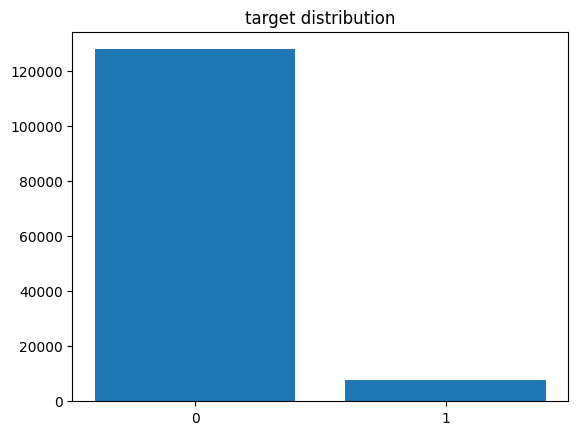

In [14]:
# Plot the ditribution of the target variable

ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

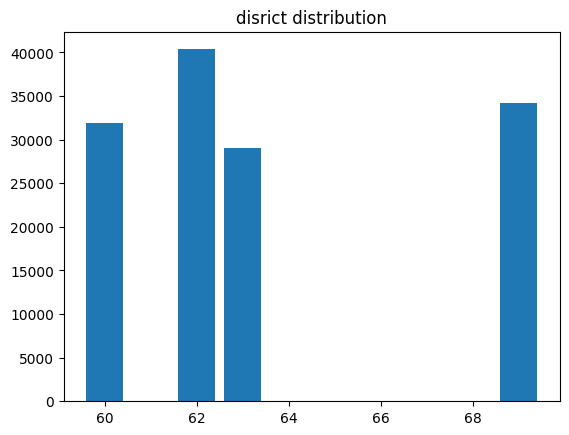

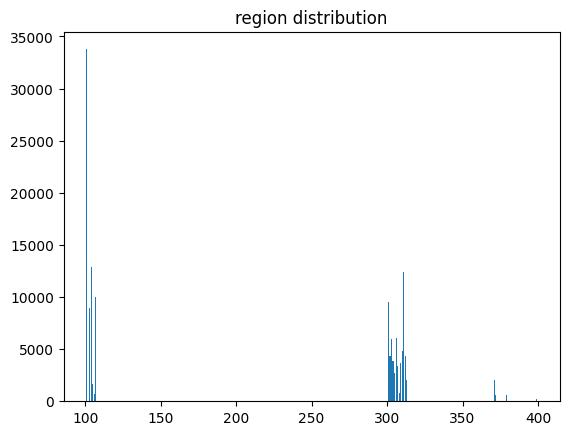

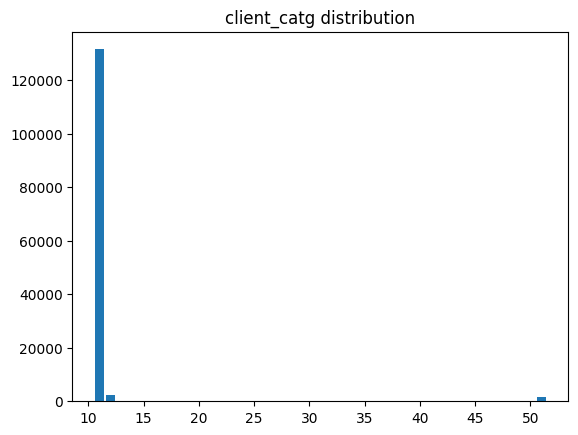

In [15]:
# Plot the distribution of the district, region, and client_catg variables

plot_these = ['disrict','region','client_catg']

for col in plot_these:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x = ds.index, height = ds.values)
    plt.title(col + ' distribution')
    plt.show()

In [16]:
# Get the number of unique values in each column in the invoice_train set

for col in invoice_train.columns:
    print(col + ":", invoice_train[col].nunique())

client_id: 135493
invoice_date: 8275
tarif_type: 17
counter_number: 201893
counter_statue: 12
counter_code: 42
reading_remarque: 8
counter_coefficient: 16
consommation_level_1: 8295
consommation_level_2: 12576
consommation_level_3: 2253
consommation_level_4: 12075
old_index: 155648
new_index: 157980
months_number: 1370
counter_type: 2


In [17]:
# ***Feature Engineering***:

In [18]:
def feature_change(client_set, invoice_set):
    
    # change the types of the following columns to category type (so we don't confuse our algorithms):
    client_set['client_catg'] = client_set['client_catg'].astype('category')
    client_set['disrict'] = client_set['disrict'].astype('category')
    client_set['region'] = client_set['region'].astype('category')
    
    client_set['region_group'] = client_set['region'].apply(lambda x: 100 if x < 100 else 300 if x > 300 else 200)
    
    # Change the type of this column to date type:
    client_set['creation_date'] = pd.to_datetime(client_set['creation_date'])
    
    client_set['coop_time'] = (2019 - client_set['creation_date'].dt.year)*12 - client_set['creation_date'].dt.month
    
    # Encode the counter_type, and counter_statue variables:
    invoice_set['counter_type'] = invoice_set['counter_type'].map({"ELEC":1,"GAZ":0})
    
    # Clean counter_statue from mislabeled values
    invoice_set['counter_statue'] = invoice_set['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    invoice_set['invoice_date'] = pd.to_datetime(invoice_set['invoice_date'], dayfirst=True)
    invoice_set['invoice_month'] = invoice_set['invoice_date'].dt.month
    invoice_set['invoice_year'] = invoice_set['invoice_date'].dt.year
    
    # Knowing if the day is weekday or not may be beneficial for us
    invoice_set['is_weekday'] = ((pd.DatetimeIndex(invoice_set.invoice_date).dayofweek) // 5 == 1).astype(float)
    
    invoice_set['delta_index'] = invoice_set['new_index'] - invoice_set['old_index']
    
    return client_set, invoice_set

In [19]:
# Apply the changes
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [20]:
# Aggregation

def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    
    # The summary operations which we are going to apply to the continous features of the invoice data
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    # Number of transactions per some amount of time
    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [21]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

In [22]:
train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [23]:
# 'max_mean' and 'range' features

def new_features(df):
    for col in agg_stat_columns:
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_max_mean'] = df[col + '_max'] / df[col + '_mean']
    
    return df

In [24]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

print(test_df2.columns)

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'region_group', 'coop_time', 'is_weekday_mean', 'transactions_count',
       'tarif_type_mean',
       ...
       'months_number_range', 'months_number_max_mean', 'counter_type_range',
       'counter_type_max_mean', 'invoice_month_range',
       'invoice_month_max_mean', 'invoice_year_range', 'invoice_year_max_mean',
       'delta_index_range', 'delta_index_max_mean'],
      dtype='object', length=110)


In [25]:
# The total number of features so far:

print(len(train_df2.columns) - 1)

110


In [26]:
# A function for dropping the unnessecary features

def drop(df):
    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [27]:
train_df = drop(train_df2)
# test_df = drop(test_df2)
test_df2.pop('creation_date')
sub = test_df2.pop('client_id')
test_df = test_df2

In [28]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

In [29]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [30]:
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb

category_cols = ['disrict', 'client_catg', 'region']

def objective(trial: Trial):
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,X,y)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore

In [31]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1200), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 600),
      'max_depth':trial.suggest_int('max_depth', 2, 150),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.0005, 0.2),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.5),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.05, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.05,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [32]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, timeout=60*60*2)

[I 2022-10-14 07:51:36,911] A new study created in memory with name: no-name-9f30806c-6c53-40e4-a7c2-799943b072ef


[LightGBM] [Warning] feature_fraction is set=0.6356755998122511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6356755998122511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6356755998122511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6356755998122511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6356755998122511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6356755998122511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6356755998122511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6356755998122511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0

[I 2022-10-14 07:53:19,310] Trial 0 finished with value: 0.8718422691246708 and parameters: {'n_estimators': 268, 'num_leaves': 121, 'max_depth': 57, 'learning_rate': 0.004480661229431988, 'min_split_gain': 0.002010935068786552, 'feature_fraction': 0.6356755998122511, 'bagging_freq': 7}. Best is trial 0 with value: 0.8718422691246708.


[LightGBM] [Warning] feature_fraction is set=0.16450101236407888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16450101236407888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16450101236407888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16450101236407888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16450101236407888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16450101236407888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.16450101236407888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16450101236407888
[LightGBM] [Warning] bagging_freq is set=4, subsampl

[I 2022-10-14 07:56:26,567] Trial 1 finished with value: 0.8817336206056801 and parameters: {'n_estimators': 1188, 'num_leaves': 186, 'max_depth': 121, 'learning_rate': 0.003704528001389483, 'min_split_gain': 0.12294823742006668, 'feature_fraction': 0.16450101236407888, 'bagging_freq': 4}. Best is trial 1 with value: 0.8817336206056801.


[LightGBM] [Warning] feature_fraction is set=0.8773406617162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773406617162723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8773406617162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773406617162723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8773406617162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773406617162723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8773406617162723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8773406617162723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

[I 2022-10-14 07:58:02,066] Trial 2 finished with value: 0.8842829429456873 and parameters: {'n_estimators': 247, 'num_leaves': 151, 'max_depth': 25, 'learning_rate': 0.02235343379143793, 'min_split_gain': 0.15341889670793973, 'feature_fraction': 0.8773406617162723, 'bagging_freq': 1}. Best is trial 2 with value: 0.8842829429456873.


[LightGBM] [Warning] feature_fraction is set=0.776441736349124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776441736349124
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.776441736349124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776441736349124
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.776441736349124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776441736349124
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.776441736349124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.776441736349124
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be

[I 2022-10-14 07:58:47,249] Trial 3 finished with value: 0.878776177760642 and parameters: {'n_estimators': 417, 'num_leaves': 238, 'max_depth': 77, 'learning_rate': 0.08198685466206976, 'min_split_gain': 0.02895590264693723, 'feature_fraction': 0.776441736349124, 'bagging_freq': 0}. Best is trial 2 with value: 0.8842829429456873.


[LightGBM] [Warning] feature_fraction is set=0.3641559802185118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3641559802185118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3641559802185118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3641559802185118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3641559802185118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3641559802185118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3641559802185118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3641559802185118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

[I 2022-10-14 08:00:21,322] Trial 4 finished with value: 0.8845710181523595 and parameters: {'n_estimators': 579, 'num_leaves': 140, 'max_depth': 148, 'learning_rate': 0.017760167165006512, 'min_split_gain': 0.0026551475553373933, 'feature_fraction': 0.3641559802185118, 'bagging_freq': 1}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.7249775029792659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249775029792659
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7249775029792659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249775029792659
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7249775029792659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249775029792659
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.7249775029792659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249775029792659
[LightGBM] [Warning] bagging_freq is set=10, subsample

[I 2022-10-14 08:04:14,849] Trial 5 finished with value: 0.8828054915767487 and parameters: {'n_estimators': 1031, 'num_leaves': 71, 'max_depth': 86, 'learning_rate': 0.004303970612038919, 'min_split_gain': 0.181486603243195, 'feature_fraction': 0.7249775029792659, 'bagging_freq': 10}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.914612950544258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.914612950544258
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.914612950544258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.914612950544258
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.914612950544258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.914612950544258
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.914612950544258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.914612950544258
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be

[I 2022-10-14 08:08:12,748] Trial 6 finished with value: 0.8831993540290618 and parameters: {'n_estimators': 1068, 'num_leaves': 188, 'max_depth': 11, 'learning_rate': 0.00929088217503061, 'min_split_gain': 0.0054972563789809975, 'feature_fraction': 0.914612950544258, 'bagging_freq': 9}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.27250868227085395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27250868227085395
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.27250868227085395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27250868227085395
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.27250868227085395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27250868227085395
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.27250868227085395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27250868227085395
[LightGBM] [Warning] bagging_freq is set=3, subsampl

[I 2022-10-14 08:09:05,516] Trial 7 finished with value: 0.8792707127849886 and parameters: {'n_estimators': 444, 'num_leaves': 411, 'max_depth': 39, 'learning_rate': 0.0329530931390335, 'min_split_gain': 0.18593170343444668, 'feature_fraction': 0.27250868227085395, 'bagging_freq': 3}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.05503444819918201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05503444819918201
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.05503444819918201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05503444819918201
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.05503444819918201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05503444819918201
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.05503444819918201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.05503444819918201
[LightGBM] [Warning] bagging_freq is set=0, subsampl

[I 2022-10-14 08:09:55,337] Trial 8 finished with value: 0.8641749341185824 and parameters: {'n_estimators': 556, 'num_leaves': 526, 'max_depth': 68, 'learning_rate': 0.025640406273230124, 'min_split_gain': 0.0010873333878289532, 'feature_fraction': 0.05503444819918201, 'bagging_freq': 0}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.6870184396239021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870184396239021
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6870184396239021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870184396239021
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6870184396239021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870184396239021
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6870184396239021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870184396239021
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0

[I 2022-10-14 08:10:03,624] Trial 9 finished with value: 0.7730225532443413 and parameters: {'n_estimators': 45, 'num_leaves': 5, 'max_depth': 139, 'learning_rate': 0.001215101359985786, 'min_split_gain': 0.23905635411233508, 'feature_fraction': 0.6870184396239021, 'bagging_freq': 9}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.41507670610777503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41507670610777503
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.41507670610777503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41507670610777503
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.41507670610777503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41507670610777503
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.41507670610777503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41507670610777503
[LightGBM] [Warning] bagging_freq is set=2, subsampl

[I 2022-10-14 08:10:30,043] Trial 10 finished with value: 0.8680367539600204 and parameters: {'n_estimators': 768, 'num_leaves': 350, 'max_depth': 113, 'learning_rate': 0.14737069010532305, 'min_split_gain': 0.010527602810961264, 'feature_fraction': 0.41507670610777503, 'bagging_freq': 2}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.4247550565797415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247550565797415
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4247550565797415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247550565797415
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4247550565797415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247550565797415
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4247550565797415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4247550565797415
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0

[I 2022-10-14 08:11:42,986] Trial 11 finished with value: 0.8810202404784142 and parameters: {'n_estimators': 784, 'num_leaves': 286, 'max_depth': 5, 'learning_rate': 0.025881902653624368, 'min_split_gain': 0.04310658901774987, 'feature_fraction': 0.4247550565797415, 'bagging_freq': 2}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.9132590687471654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132590687471654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9132590687471654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132590687471654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9132590687471654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132590687471654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9132590687471654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132590687471654
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

[I 2022-10-14 08:12:33,180] Trial 12 finished with value: 0.8769886883848178 and parameters: {'n_estimators': 136, 'num_leaves': 114, 'max_depth': 43, 'learning_rate': 0.015552976870094293, 'min_split_gain': 0.06006515596350123, 'feature_fraction': 0.9132590687471654, 'bagging_freq': 6}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.5098778318510018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098778318510018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5098778318510018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098778318510018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5098778318510018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098778318510018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5098778318510018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5098778318510018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

[I 2022-10-14 08:12:58,591] Trial 13 finished with value: 0.877023857476785 and parameters: {'n_estimators': 277, 'num_leaves': 11, 'max_depth': 148, 'learning_rate': 0.07439090182202977, 'min_split_gain': 0.48423102021756376, 'feature_fraction': 0.5098778318510018, 'bagging_freq': 1}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.2838266193358362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2838266193358362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2838266193358362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2838266193358362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2838266193358362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2838266193358362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2838266193358362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2838266193358362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0

[I 2022-10-14 08:15:06,260] Trial 14 finished with value: 0.863258198269343 and parameters: {'n_estimators': 768, 'num_leaves': 156, 'max_depth': 98, 'learning_rate': 0.0005964909550697431, 'min_split_gain': 0.005397644125607874, 'feature_fraction': 0.2838266193358362, 'bagging_freq': 4}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.971110114934951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971110114934951
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.971110114934951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971110114934951
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.971110114934951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971110114934951
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.971110114934951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.971110114934951
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be

[I 2022-10-14 08:20:32,292] Trial 15 finished with value: 0.884085681059485 and parameters: {'n_estimators': 595, 'num_leaves': 262, 'max_depth': 24, 'learning_rate': 0.009166610220437982, 'min_split_gain': 0.012102990578150391, 'feature_fraction': 0.971110114934951, 'bagging_freq': 2}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.549306010980965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549306010980965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.549306010980965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549306010980965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.549306010980965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549306010980965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.549306010980965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.549306010980965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be

[I 2022-10-14 08:21:32,255] Trial 16 finished with value: 0.8805995696476672 and parameters: {'n_estimators': 298, 'num_leaves': 376, 'max_depth': 117, 'learning_rate': 0.04766359756881384, 'min_split_gain': 0.07173706769288503, 'feature_fraction': 0.549306010980965, 'bagging_freq': 5}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.8193223789368465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8193223789368465
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8193223789368465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8193223789368465
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8193223789368465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8193223789368465
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8193223789368465, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8193223789368465
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0

[I 2022-10-14 08:21:45,464] Trial 17 finished with value: 0.8599104641949055 and parameters: {'n_estimators': 13, 'num_leaves': 458, 'max_depth': 51, 'learning_rate': 0.012150266985699983, 'min_split_gain': 0.0031247266523514532, 'feature_fraction': 0.8193223789368465, 'bagging_freq': 0}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.34435985385710616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34435985385710616
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.34435985385710616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34435985385710616
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.34435985385710616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34435985385710616
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.34435985385710616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34435985385710616
[LightGBM] [Warning] bagging_freq is set=3, subsampl

[I 2022-10-14 08:22:50,591] Trial 18 finished with value: 0.8655456712543484 and parameters: {'n_estimators': 452, 'num_leaves': 76, 'max_depth': 30, 'learning_rate': 0.002313710586340521, 'min_split_gain': 0.019674513374535095, 'feature_fraction': 0.34435985385710616, 'bagging_freq': 3}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.5630551043805861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630551043805861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5630551043805861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630551043805861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5630551043805861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630551043805861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5630551043805861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5630551043805861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

[I 2022-10-14 08:23:53,641] Trial 19 finished with value: 0.8819887361712505 and parameters: {'n_estimators': 178, 'num_leaves': 221, 'max_depth': 99, 'learning_rate': 0.01948564483269584, 'min_split_gain': 0.48095810540889394, 'feature_fraction': 0.5630551043805861, 'bagging_freq': 1}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.21129110159607908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21129110159607908
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.21129110159607908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21129110159607908
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.21129110159607908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21129110159607908
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.21129110159607908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21129110159607908
[LightGBM] [Warning] bagging_freq is set=7, subsampl

[I 2022-10-14 08:24:14,691] Trial 20 finished with value: 0.8527583875083792 and parameters: {'n_estimators': 693, 'num_leaves': 586, 'max_depth': 135, 'learning_rate': 0.15559596569665196, 'min_split_gain': 0.016108247981455284, 'feature_fraction': 0.21129110159607908, 'bagging_freq': 7}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.9936847980257045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936847980257045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9936847980257045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936847980257045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9936847980257045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936847980257045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9936847980257045, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9936847980257045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0

[I 2022-10-14 08:30:00,045] Trial 21 finished with value: 0.883576502951209 and parameters: {'n_estimators': 591, 'num_leaves': 283, 'max_depth': 22, 'learning_rate': 0.008497672834487147, 'min_split_gain': 0.009348666077772938, 'feature_fraction': 0.9936847980257045, 'bagging_freq': 2}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.990285405423708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990285405423708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.990285405423708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990285405423708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.990285405423708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990285405423708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.990285405423708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990285405423708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be

[I 2022-10-14 08:34:50,937] Trial 22 finished with value: 0.8840783141906883 and parameters: {'n_estimators': 904, 'num_leaves': 246, 'max_depth': 25, 'learning_rate': 0.009845379374260646, 'min_split_gain': 0.0010429127773631435, 'feature_fraction': 0.990285405423708, 'bagging_freq': 1}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.8523795448760579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523795448760579
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8523795448760579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523795448760579
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8523795448760579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523795448760579
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8523795448760579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523795448760579
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0

[I 2022-10-14 08:39:51,324] Trial 23 finished with value: 0.8827847500632748 and parameters: {'n_estimators': 534, 'num_leaves': 341, 'max_depth': 13, 'learning_rate': 0.006394980601395, 'min_split_gain': 0.0028600066431147273, 'feature_fraction': 0.8523795448760579, 'bagging_freq': 3}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.8894032150868695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894032150868695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8894032150868695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894032150868695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8894032150868695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894032150868695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8894032150868695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8894032150868695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0

[I 2022-10-14 08:41:12,161] Trial 24 finished with value: 0.8832936961012454 and parameters: {'n_estimators': 650, 'num_leaves': 148, 'max_depth': 64, 'learning_rate': 0.035467644084350415, 'min_split_gain': 0.0069609267952633405, 'feature_fraction': 0.8894032150868695, 'bagging_freq': 1}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.4446241092765233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446241092765233
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4446241092765233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446241092765233
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4446241092765233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446241092765233
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4446241092765233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4446241092765233
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0

[I 2022-10-14 08:41:36,542] Trial 25 finished with value: 0.861000523398307 and parameters: {'n_estimators': 360, 'num_leaves': 77, 'max_depth': 2, 'learning_rate': 0.057522269494571135, 'min_split_gain': 0.030079696100624085, 'feature_fraction': 0.4446241092765233, 'bagging_freq': 2}. Best is trial 4 with value: 0.8845710181523595.


[LightGBM] [Warning] feature_fraction is set=0.6264746653508504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6264746653508504
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6264746653508504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6264746653508504
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6264746653508504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6264746653508504
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6264746653508504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6264746653508504
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0

[I 2022-10-14 08:43:49,169] Trial 26 finished with value: 0.885121328594091 and parameters: {'n_estimators': 870, 'num_leaves': 192, 'max_depth': 39, 'learning_rate': 0.017143378160249082, 'min_split_gain': 0.0020268663182946905, 'feature_fraction': 0.6264746653508504, 'bagging_freq': 4}. Best is trial 26 with value: 0.885121328594091.


[LightGBM] [Warning] feature_fraction is set=0.681599340836847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681599340836847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.681599340836847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681599340836847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.681599340836847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681599340836847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.681599340836847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.681599340836847
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be

[I 2022-10-14 08:45:54,772] Trial 27 finished with value: 0.8851930559347074 and parameters: {'n_estimators': 898, 'num_leaves': 212, 'max_depth': 50, 'learning_rate': 0.018492029959151023, 'min_split_gain': 0.0018628573046372456, 'feature_fraction': 0.681599340836847, 'bagging_freq': 5}. Best is trial 27 with value: 0.8851930559347074.


[LightGBM] [Warning] feature_fraction is set=0.6397980263669172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397980263669172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6397980263669172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397980263669172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6397980263669172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397980263669172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6397980263669172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6397980263669172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0

[I 2022-10-14 08:48:11,208] Trial 28 finished with value: 0.8853192676410826 and parameters: {'n_estimators': 904, 'num_leaves': 201, 'max_depth': 45, 'learning_rate': 0.01613035945984143, 'min_split_gain': 0.0015877552481347065, 'feature_fraction': 0.6397980263669172, 'bagging_freq': 5}. Best is trial 28 with value: 0.8853192676410826.


[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

[I 2022-10-14 08:53:37,548] Trial 29 finished with value: 0.886153456434562 and parameters: {'n_estimators': 924, 'num_leaves': 202, 'max_depth': 55, 'learning_rate': 0.005968705689601583, 'min_split_gain': 0.002112551463720949, 'feature_fraction': 0.6286048610274739, 'bagging_freq': 6}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.6348244298213286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348244298213286
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6348244298213286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348244298213286
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6348244298213286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348244298213286
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6348244298213286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348244298213286
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

[I 2022-10-14 09:01:36,823] Trial 30 finished with value: 0.8822761492687053 and parameters: {'n_estimators': 950, 'num_leaves': 321, 'max_depth': 55, 'learning_rate': 0.002544215949066995, 'min_split_gain': 0.0016261909999399232, 'feature_fraction': 0.6348244298213286, 'bagging_freq': 6}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.6417812212797335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6417812212797335
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6417812212797335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6417812212797335
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6417812212797335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6417812212797335
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6417812212797335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6417812212797335
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0

[I 2022-10-14 09:04:11,878] Trial 31 finished with value: 0.8857083274088305 and parameters: {'n_estimators': 896, 'num_leaves': 192, 'max_depth': 41, 'learning_rate': 0.013713922434708675, 'min_split_gain': 0.0017471407277216363, 'feature_fraction': 0.6417812212797335, 'bagging_freq': 5}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.7195365383519782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195365383519782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7195365383519782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195365383519782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7195365383519782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195365383519782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7195365383519782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195365383519782
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

[I 2022-10-14 09:11:00,791] Trial 32 finished with value: 0.8857051876947523 and parameters: {'n_estimators': 1153, 'num_leaves': 219, 'max_depth': 47, 'learning_rate': 0.0056320155384243014, 'min_split_gain': 0.0015680190205359524, 'feature_fraction': 0.7195365383519782, 'bagging_freq': 6}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.7589424483664532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589424483664532
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7589424483664532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589424483664532
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7589424483664532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589424483664532
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7589424483664532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589424483664532
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0

[I 2022-10-14 09:16:02,474] Trial 33 finished with value: 0.8852034935762896 and parameters: {'n_estimators': 1160, 'num_leaves': 109, 'max_depth': 64, 'learning_rate': 0.006440508136629824, 'min_split_gain': 0.004370713236646644, 'feature_fraction': 0.7589424483664532, 'bagging_freq': 7}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.5926932327662477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926932327662477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5926932327662477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926932327662477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5926932327662477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926932327662477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5926932327662477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5926932327662477
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

[I 2022-10-14 09:21:44,578] Trial 34 finished with value: 0.8831933635639002 and parameters: {'n_estimators': 1107, 'num_leaves': 170, 'max_depth': 74, 'learning_rate': 0.0030130919860222607, 'min_split_gain': 0.0013278140543871665, 'feature_fraction': 0.5926932327662477, 'bagging_freq': 6}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.4769985246734172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769985246734172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4769985246734172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769985246734172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4769985246734172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769985246734172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4769985246734172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4769985246734172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0

[I 2022-10-14 09:26:58,762] Trial 35 finished with value: 0.8856851503606858 and parameters: {'n_estimators': 1013, 'num_leaves': 255, 'max_depth': 44, 'learning_rate': 0.005774774976872141, 'min_split_gain': 0.003825403065738436, 'feature_fraction': 0.4769985246734172, 'bagging_freq': 5}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.47589710328204604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47589710328204604
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.47589710328204604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47589710328204604
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.47589710328204604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47589710328204604
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.47589710328204604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47589710328204604
[LightGBM] [Warning] bagging_freq is set=8, subsampl

[I 2022-10-14 09:32:23,113] Trial 36 finished with value: 0.8859989169476916 and parameters: {'n_estimators': 989, 'num_leaves': 258, 'max_depth': 33, 'learning_rate': 0.005400108125940364, 'min_split_gain': 0.00387681257814178, 'feature_fraction': 0.47589710328204604, 'bagging_freq': 8}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.794465151807983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794465151807983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.794465151807983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794465151807983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.794465151807983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794465151807983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.794465151807983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794465151807983
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be

[I 2022-10-14 09:43:37,390] Trial 37 finished with value: 0.8813450864885695 and parameters: {'n_estimators': 1200, 'num_leaves': 305, 'max_depth': 34, 'learning_rate': 0.0019067329918902637, 'min_split_gain': 0.0023054803088951043, 'feature_fraction': 0.794465151807983, 'bagging_freq': 8}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.7256254665113973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256254665113973
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7256254665113973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256254665113973
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7256254665113973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256254665113973
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7256254665113973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256254665113973
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

[I 2022-10-14 09:50:58,447] Trial 38 finished with value: 0.884829472066297 and parameters: {'n_estimators': 990, 'num_leaves': 232, 'max_depth': 83, 'learning_rate': 0.004161376818197055, 'min_split_gain': 0.003558249268405999, 'feature_fraction': 0.7256254665113973, 'bagging_freq': 8}. Best is trial 29 with value: 0.886153456434562.


[LightGBM] [Warning] feature_fraction is set=0.5215705680358155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215705680358155
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5215705680358155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215705680358155
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5215705680358155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215705680358155
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.5215705680358155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5215705680358155
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

[I 2022-10-14 09:57:52,556] Trial 39 finished with value: 0.8800757951792895 and parameters: {'n_estimators': 1107, 'num_leaves': 275, 'max_depth': 60, 'learning_rate': 0.0016905488356461725, 'min_split_gain': 0.007030281973964364, 'feature_fraction': 0.5215705680358155, 'bagging_freq': 8}. Best is trial 29 with value: 0.886153456434562.


In [38]:
'''

Trial 29 finished with value: 0.886153456434562 and parameters: {'n_estimators': 924,
'num_leaves': 202, 'max_depth': 55, 'learning_rate': 0.005968705689601583,
'min_split_gain': 0.002112551463720949, 'feature_fraction': 0.6286048610274739,
'bagging_freq': 6}. Best is trial 29 with value: 0.886153456434562.

'''

# Then our best model so far is:

model = LGBMClassifier(random_state=seed, n_estimators=924, num_leaves = 202, max_depth = 55,
                       learning_rate = 0.005968705689601583, min_split_gain = 0.002112551463720949, 
                       feature_fraction = 0.6286048610274739, bagging_freq = 6)
                       

In [39]:
stkfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [40]:
%%time
probs = calc(X, y, model, stkfold)

[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6286048610274739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6286048610274739
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0

In [41]:
# Submitting

submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('submission - idea #1.csv', index = False)